In [116]:
#import numpy as np
import pandas as pd

rm_exp = pd.read_csv('data/expression/57epigenomes.RPKM.pc.gz',delimiter="\t")

In [105]:
#get list of id's which we have expression data for
exp_ids = list(rm_exp.columns.values)[2:]

In [106]:
import urllib.request
from bs4 import BeautifulSoup

target_url = 'https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/pval/'
data = urllib.request.urlopen(target_url)

soup = BeautifulSoup(data, "html.parser").find_all(lambda t: t.name == "a")
#get https
links = [a["href"] for a in soup][5:]

#convert df and split by assay
epi_dat = pd.DataFrame({'link':links})
epi_dat[['id','mix']] = epi_dat['link'].str.split('-',expand=True)
epi_dat['assay'] = epi_dat['mix'].str.split('.').str[0]

In [107]:
#filter to the cases with expression data
epi_dat = epi_dat[epi_dat['id'].isin(exp_ids)]

<AxesSubplot:>

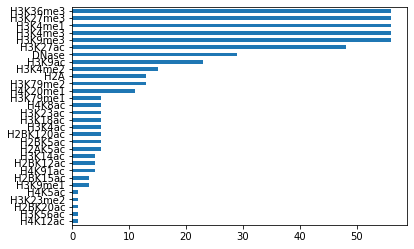

In [108]:
#let's have a look at which assays are available in cells/tissues
epi_dat.assay.value_counts().sort_values().plot(kind = 'barh')

In [109]:
#take 12 assays, down to H3K4me2
assays = epi_dat.assay.value_counts().sort_values(ascending=False).index[0:12]

In [110]:
#get id's
exp_epi_ids = []
for cell in exp_ids:
    if(set(assays).issubset(epi_dat[epi_dat['id']==cell].assay.values)):
        exp_epi_ids.append(cell)
print(f"There are {len(exp_epi_ids)} cells/tissues with all assays:")
print(assays.values)

There are 11 cells/tissues with all assays:
['H3K36me3' 'H3K4me1' 'H3K4me3' 'H3K9me3' 'H3K27me3' 'H3K27ac' 'DNase'
 'H3K9ac' 'H3K4me2' 'H2A' 'H3K79me2' 'H4K20me1']


In [111]:
#get cell/tissue names for these ids
id_names = 'https://egg2.wustl.edu/roadmap/data/byDataType/rna/expression/EG.name.txt'
id_names = pd.read_csv(id_names, header=None, sep='\s+')
id_names.rename(columns={0: 'id', 1: 'cell_tissue'},inplace=True)

In [112]:
#so training sampels all seem to be cell lines
id_names[id_names['id'].isin(exp_epi_ids)]

,id,cell_tissue
1,E003,H1_Cell_Line
47,E114,A549
48,E116,GM12878
49,E117,HELA
50,E118,HEPG2
51,E119,HMEC
52,E120,HSMM
53,E122,HUVEC
54,E123,K562
55,E127,NHEK


In [113]:
#Finally get download links
epi_dat = epi_dat[epi_dat['id'].isin(exp_epi_ids)]
pge_url = 'https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/pval/'
epi_dat['link'] = pge_url+epi_dat['link']
#creat df with just id and link
epi_urls = epi_dat[['id', 'link']].copy()
epi_urls.rename(columns={'id': 'name'},inplace=True)

In [115]:
#save metadata
for assay in assays:
    epi_urls[epi_dat['assay']==assay].to_csv(f'./metadata/{assay}.csv',index=False)